In [19]:
# import packages
import xarray as xr
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import mapping
import rioxarray

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.colors import ListedColormap

In [2]:
# define files
path_lc = '/work/lh88wasu-BA_Portugal/Data/LCCS/resampled/ESACCI-LC-L4-LCCS-Map-300m-P1Y-2019-v2.1.1_agg_1km.nc'
path_pt = "/home/sc.uni-leipzig.de/lu942pyci/Masterthesis/Data/Portugal_shp/PT_continental.shp"  # Path to Portugal shapefile
path_fig = '/home/sc.uni-leipzig.de/lu942pyci/Masterthesis/Figures/'
path_pa = "/home/sc.uni-leipzig.de/lu942pyci/Masterthesis/Data/WDPA/"

In [3]:
# open data (LC and Portugal shapefile)
ds = xr.open_dataset(path_lc)
pt_shape = gpd.read_file(path_pt)

In [4]:
# project LC data to EPSG 4326
ds.rio.write_crs("epsg:4326", inplace=True)
data = ds.copy()
data = data.rename({'lat': 'y', 'lon': 'x'})

In [5]:
# replace non-finite values
data = data.where(np.isfinite(data), np.nan)

In [6]:
# clip to Portugal shape
clipped = data.rio.clip(pt_shape.geometry.values, pt_shape.crs, drop=True)

In [7]:
# filter to only have forest as LC type
filtered_data = clipped.where((clipped >= 1) & (clipped <= 3))
filtered_data = filtered_data.isel(time=0)

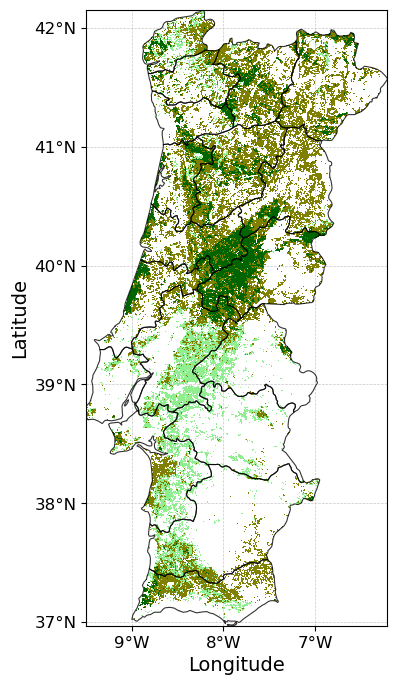

In [33]:
## Plot LC in mainland Portugal
cmap = ListedColormap(['lightgreen', 'darkgreen', 'olive'])

# Step 3: Plot the filtered data with the custom colormap
fig, ax = plt.subplots(figsize=(15, 8))

# Use imshow() to plot the data with the custom colormap
plot = filtered_data['lccs_class_new'].plot(ax = ax, cmap=cmap, add_colorbar=False)

# Add a colorbar for the Land Cover
cbar = plt.colorbar(plot, ax=ax, ticks=[1, 2, 3])
cbar.set_label('Forest Types', fontsize=14)
cbar.set_ticks([1.4, 2.1, 2.7])
cbar.set_ticklabels(['Broadleaf', 'Needleleaf', 'Mixed'])
cbar.ax.tick_params(length=0, labelsize=12)

# Rotate the colorbar labels by 90 degrees
for tick in cbar.ax.get_yticklabels():
    tick.set_rotation(90)
    
# Add the Portugal shape outline
pt_shape.boundary.plot(ax=ax, color="black", linewidth=.8, alpha=.8)

# Add labels, title, and save the figure
ax.set_xlabel("Longitude", fontsize=14)
ax.set_ylabel("Latitude", fontsize=14)
plt.title('')
ax.tick_params(axis='both', labelsize=12)

# Format tick labels with °N and °W
def format_lat(lat, pos):
    return f"{abs(lat):.0f}°{'N' if lat >= 0 else 'S'}"

def format_lon(lon, pos):
    return f"{abs(lon):.0f}°{'E' if lon >= 0 else 'W'}"

ax.xaxis.set_major_formatter(mticker.FuncFormatter(format_lon))
ax.yaxis.set_major_formatter(mticker.FuncFormatter(format_lat))

plt.title('')

# Add grid behind the axis tick labels
ax.set_axisbelow(True)
ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)

plt.savefig(path_fig + 'LC_forest_Map.png', bbox_inches='tight', dpi=250)

## WDPA

In [10]:
wdpa = xr.open_dataset(path_pa + 'WDPA_PT_rasterized_agg2.nc')

In [11]:
sub = wdpa.where((wdpa['PA_status'] == 1))
sub

<xarray.Dataset>
Dimensions:    (Latitude: 577, Longitude: 366)
Coordinates:
  * Longitude  (Longitude) float64 -9.499 -9.49 -9.481 ... -6.232 -6.223 -6.214
  * Latitude   (Latitude) float64 42.15 42.15 42.14 42.13 ... 36.99 36.98 36.97
Data variables:
    PA_status  (Latitude, Longitude) float64 nan nan nan nan ... nan nan nan nan
    PA_year    (Latitude, Longitude) float64 nan nan nan nan ... nan nan nan nan
Attributes:
    crs:          EPSG:4326
    description:  Protected Areas Dataset

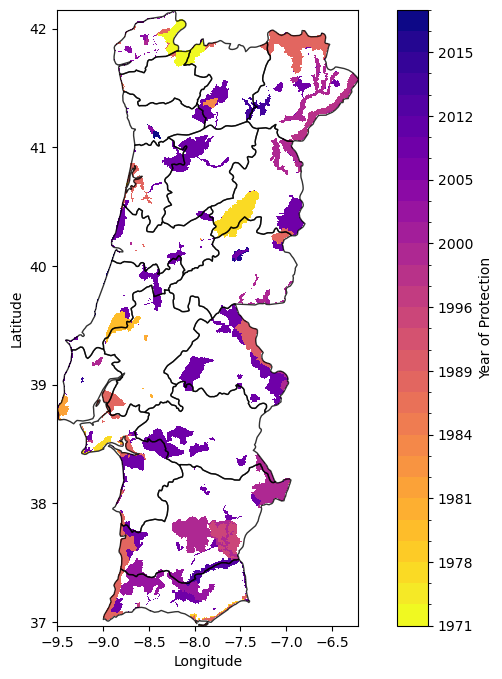

In [12]:
pa_year_data = sub['PA_year'].where(~sub['PA_year'].isnull())
unique_years = np.unique(pa_year_data.values[~np.isnan(pa_year_data.values)])

# Plot the data with Spectral colormap
fig, ax = plt.subplots(figsize=(10, 8))

plot = pa_year_data.plot(ax=ax, cmap='plasma_r', levels=unique_years, add_colorbar=False)
cbar = plt.colorbar(plot, ax=ax)
cbar.set_label('Year of Protection')

pt_shape.boundary.plot(ax=ax, color="black", linewidth=1, alpha=.8)

plt.title("")

plt.savefig(path_fig + 'PA_Map_years.png', bbox_inches='tight', dpi=250)

## Plot LC and PA

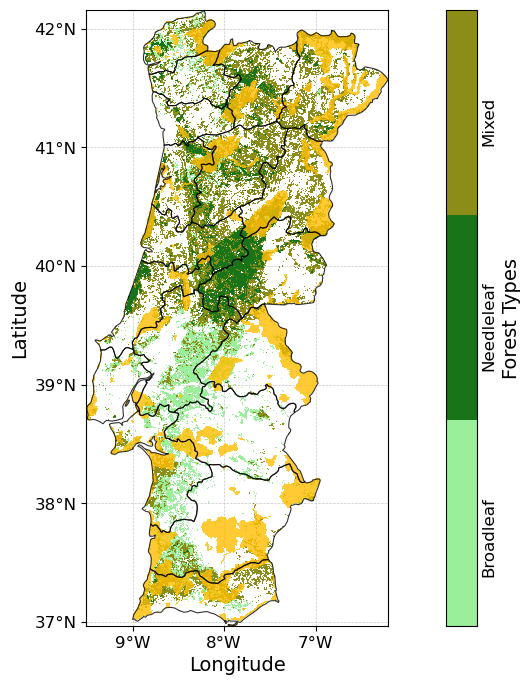

In [26]:
# Define the colormap for Land Cover
cmap = ListedColormap(['lightgreen', 'darkgreen', 'olive'])

# Create the figure and axis
fig, ax = plt.subplots(figsize=(15, 8))

# Plot the Land Cover data with the custom colormap
plot = filtered_data['lccs_class_new'].plot(ax=ax, cmap=cmap, add_colorbar=False, alpha=.9)

# Add a colorbar for the Land Cover
cbar = plt.colorbar(plot, ax=ax, ticks=[1, 2, 3])
cbar.set_label('Forest Types', fontsize=14)
cbar.set_ticks([1.4, 2.1, 2.7])
cbar.set_ticklabels(['Broadleaf', 'Needleleaf', 'Mixed'])
cbar.ax.tick_params(length=0, labelsize=12)

# Rotate the colorbar labels by 90 degrees
for tick in cbar.ax.get_yticklabels():
    tick.set_rotation(90)

# Overlay the protected areas
# Convert PA data to a binary mask (1 for protected, NaN for unprotected)
pa_mask = sub['PA_status'].where(sub['PA_status'] == 1)

# Plot the protected areas as a semi-transparent purple overlay
pa_mask.plot(ax=ax, cmap='Wistia', alpha=0.8, add_colorbar=False)

# Add the Portugal shape outline
pt_shape.boundary.plot(ax=ax, color="black", linewidth=.8, alpha=.8)

# Add labels, title, and save the figure
ax.set_xlabel("Longitude", fontsize=14)
ax.set_ylabel("Latitude", fontsize=14)
plt.title('')
ax.tick_params(axis='both', labelsize=12)

# Format tick labels with °N and °W
def format_lat(lat, pos):
    return f"{abs(lat):.0f}°{'N' if lat >= 0 else 'S'}"

def format_lon(lon, pos):
    return f"{abs(lon):.0f}°{'E' if lon >= 0 else 'W'}"

ax.xaxis.set_major_formatter(mticker.FuncFormatter(format_lon))
ax.yaxis.set_major_formatter(mticker.FuncFormatter(format_lat))

ax.set_axisbelow(True)
ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)

plt.savefig(path_fig + 'LC_with_PA_Map.png', bbox_inches='tight', dpi=250)



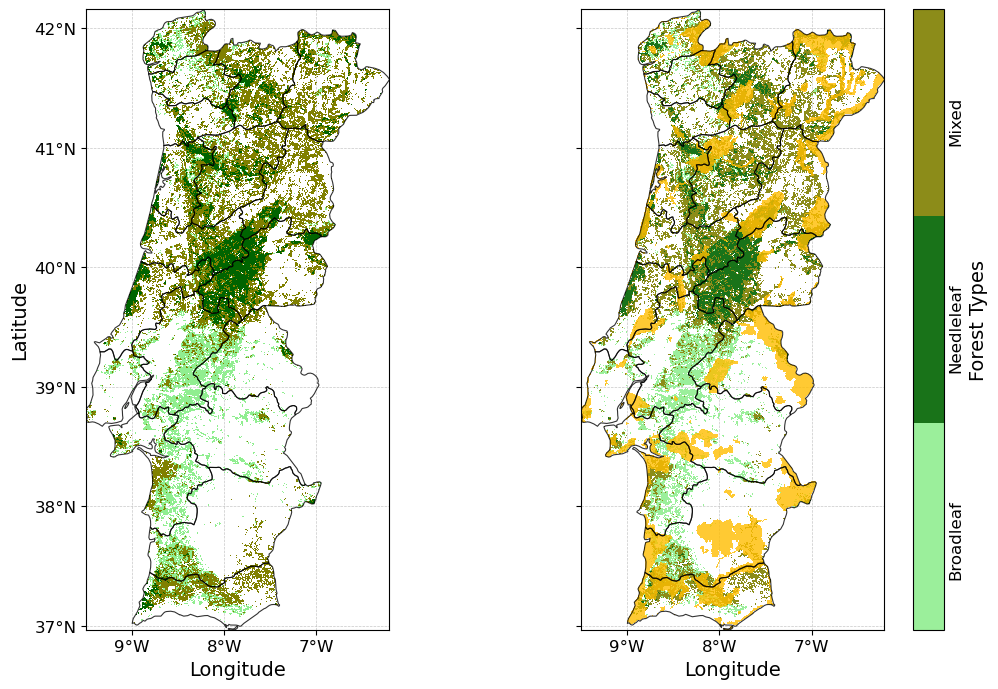

In [42]:
## Plot both together

# Define the colormap for Land Cover
cmap = ListedColormap(['lightgreen', 'darkgreen', 'olive'])

# Create the figure and two subplots (side by side)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(11, 7), sharey=True)

# Left subplot: Land Cover data (no colorbar)
ax = axes[0]

# Plot the filtered data with the custom colormap
plot = filtered_data['lccs_class_new'].plot(ax=ax, cmap=cmap, add_colorbar=False)

# Add the Portugal shape outline
pt_shape.boundary.plot(ax=ax, color="black", linewidth=.8, alpha=.8)

# Add labels, title, and customize ticks
ax.set_xlabel("Longitude", fontsize=14)
ax.set_ylabel("Latitude", fontsize=14)
ax.tick_params(axis='both', labelsize=12)
ax.set_title('')

# Format tick labels with °N and °W
def format_lat(lat, pos):
    return f"{abs(lat):.0f}°{'N' if lat >= 0 else 'S'}"

def format_lon(lon, pos):
    return f"{abs(lon):.0f}°{'E' if lon >= 0 else 'W'}"

ax.xaxis.set_major_formatter(mticker.FuncFormatter(format_lon))
ax.yaxis.set_major_formatter(mticker.FuncFormatter(format_lat))

ax.set_axisbelow(True)
ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)


# Right subplot: Land Cover + Protected Areas data (with colorbar)
ax = axes[1]

# Plot the Land Cover data with the custom colormap
plot = filtered_data['lccs_class_new'].plot(ax=ax, cmap=cmap, add_colorbar=False, alpha=.9)

# Overlay the protected areas
pa_mask = sub['PA_status'].where(sub['PA_status'] == 1)  # Binary mask for protected areas
pa_mask.plot(ax=ax, cmap='Wistia', alpha=0.8, add_colorbar=False)

# Add the Portugal shape outline
pt_shape.boundary.plot(ax=ax, color="black", linewidth=.8, alpha=.8)

# Add labels, title, and customize ticks
ax.set_xlabel("Longitude", fontsize=14)
ax.set_title('')
ax.tick_params(axis='both', labelsize=12)

# Remove the y-label from the right subplot
ax.set_ylabel('')

# Format tick labels with °N and °W
ax.xaxis.set_major_formatter(mticker.FuncFormatter(format_lon))
ax.yaxis.set_major_formatter(mticker.FuncFormatter(format_lat))

# Add grid behind the axis ticks
ax.set_axisbelow(True)
ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)

# Add a colorbar for the Land Cover data (only in the right subplot)
cbar = plt.colorbar(plot, ax=ax, ticks=[1, 2, 3])
cbar.set_label('Forest Types', fontsize=14)
cbar.set_ticks([1.4, 2.1, 2.7])
cbar.set_ticklabels(['Broadleaf', 'Needleleaf', 'Mixed'])
cbar.ax.tick_params(length=0, labelsize=12)

# Rotate the colorbar labels by 90 degrees
for tick in cbar.ax.get_yticklabels():
    tick.set_rotation(90)

# Adjust layout to make space for the colorbar and labels
plt.tight_layout(rect=[0, 0, 1, 1])  # Ensure tight layout and avoid overlap

plt.savefig(path_fig + 'LC_and_PA_Map.png', bbox_inches='tight', dpi=250)
